# Imports

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Load Data

In [2]:
# Install kaggle package
#!pip install kaggle

# Upload kaggle.json
from google.colab import files
files.upload()

# Create ~/.kaggle folder and move kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d tungxnguyen/corrosionannotated

Saving kaggle.json to kaggle.json
 93% 43.0M/46.2M [00:01<00:00, 27.5MB/s]
100% 46.2M/46.2M [00:01<00:00, 41.5MB/s]


In [3]:
# Unzip file 
import zipfile
with zipfile.ZipFile('/content/corrosionannotated.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [4]:
# Change directory name
!mv /content/JPEGImages /content/images
!mv /content/SegmentationClassPNG/ /content/masks

# Data Preparation

In [5]:
images_dir = "/content/images"
masks_dir = "/content/masks"

images_path = sorted([os.path.join(images_dir, fname) for fname in os.listdir(images_dir) if fname.endswith(".jpg")])
masks_path = sorted([os.path.join(masks_dir, fname) for fname in os.listdir(masks_dir) if fname.endswith(".png")])

print(images_path)
print(masks_path)

print("Number of images : ", len(images_path))
print("Number of masks : ", len(masks_path))

['/content/images/IMG_0112.jpg', '/content/images/img0.jpg', '/content/images/img1.jpg', '/content/images/img10.jpg', '/content/images/img100.jpg', '/content/images/img101.jpg', '/content/images/img102.jpg', '/content/images/img103.jpg', '/content/images/img104.jpg', '/content/images/img105.jpg', '/content/images/img106.jpg', '/content/images/img107.jpg', '/content/images/img108.jpg', '/content/images/img109.jpg', '/content/images/img11.jpg', '/content/images/img110.jpg', '/content/images/img111.jpg', '/content/images/img112.jpg', '/content/images/img113.jpg', '/content/images/img114.jpg', '/content/images/img115.jpg', '/content/images/img116.jpg', '/content/images/img117.jpg', '/content/images/img119.jpg', '/content/images/img12.jpg', '/content/images/img120.jpg', '/content/images/img121.jpg', '/content/images/img122.jpg', '/content/images/img123.jpg', '/content/images/img124.jpg', '/content/images/img125.jpg', '/content/images/img126.jpg', '/content/images/img127.jpg', '/content/imag

In [6]:
# Split data into train data and validation data
from sklearn.model_selection import train_test_split

train_img_path, test_img_path, train_mask_path, test_mask_path = train_test_split(images_path, masks_path, test_size=0.1, random_state=42)

print(train_img_path)
print(train_mask_path)

print("Train images and masks : ", len(train_img_path), "|", len(train_mask_path))
print("Test images and masks : ", len(test_img_path), "|", len(test_mask_path))

['/content/images/png7.jpg', '/content/images/img64.jpg', '/content/images/img106.jpg', '/content/images/img35.jpg', '/content/images/img28.jpg', '/content/images/img187.jpg', '/content/images/img234.jpg', '/content/images/png3.jpg', '/content/images/img77.jpg', '/content/images/img120.jpg', '/content/images/img177.jpg', '/content/images/img113.jpg', '/content/images/img166.jpg', '/content/images/img223.jpg', '/content/images/img51.jpg', '/content/images/img3.jpg', '/content/images/img93.jpg', '/content/images/img247.jpg', '/content/images/img139.jpg', '/content/images/img158.jpg', '/content/images/img111.jpg', '/content/images/img159.jpg', '/content/images/img63.jpg', '/content/images/img58.jpg', '/content/images/img30.jpg', '/content/images/img132.jpg', '/content/images/img23.jpg', '/content/images/img175.jpg', '/content/images/img148.jpg', '/content/images/img74.jpg', '/content/images/img193.jpg', '/content/images/img226.jpg', '/content/images/img214.jpg', '/content/images/img152.jp

# Data Preparation

In [7]:
def preprocessing(img, msk):
  length = len(img)

  img_tensor = np.zeros((length, 256, 256, 3), dtype='float')
  msk_tensor = np.zeros((length, 256, 256, 1), dtype='float')

  for i in range(length):

    # Image preprocessing
    x = cv2.imread(img[i], cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x / 255.
    x = x.astype('float')
    x = x.reshape(256, 256, 3)

    # Mask preprocessing
    y = cv2.imread(msk[i], cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (256, 256))
    y = y / 255.
    y = y.astype('float')
    y = y.reshape(256, 256, 1)

    img_tensor[i] = x
    msk_tensor[i] = y

  return img_tensor, msk_tensor


In [8]:
train_img, train_mask = preprocessing(train_img_path, train_mask_path)
test_img, test_mask = preprocessing(test_img_path, test_mask_path)

print(train_img.shape)

(227, 256, 256, 3)


# Build Model

In [9]:
#Build model
inputs = tf.keras.layers.Input((256, 256, 3))

#Contraction path
conv1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
conv1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(conv1)
pool1 = tf.keras.layers.MaxPooling2D((2,2))(conv1)
pool1 = tf.keras.layers.Dropout(0.25)(pool1)

conv2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(pool1)
conv2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv2)
pool2 = tf.keras.layers.MaxPooling2D((2,2))(conv2)
pool2 = tf.keras.layers.Dropout(0.5)(pool2)

conv3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(pool2)
conv3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv3)
pool3 = tf.keras.layers.MaxPooling2D((2,2))(conv3)
pool3 = tf.keras.layers.Dropout(0.5)(pool3)

conv4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(pool3)
conv4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv4)
pool4 = tf.keras.layers.MaxPooling2D((2,2))(conv4)
pool4 = tf.keras.layers.Dropout(0.5)(pool4)
 
# Middle
convmid = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(pool4)
convmid = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(convmid)

# Expansive Path (conv_2d_transpose -> concatenate -> conv_layer1 -> conv_layer2)
ctrans4 = tf.keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(convmid)
upconv4 = tf.keras.layers.concatenate([ctrans4, conv4])
upconv4 = tf.keras.layers.Dropout(0.5)(upconv4)
upconv4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(upconv4)
upconv4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(upconv4)

ctrans3 = tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(upconv4)
upconv3 = tf.keras.layers.concatenate([ctrans3, conv3])
upconv3 = tf.keras.layers.Dropout(0.5)(upconv3)
upconv3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(upconv3)
upconv3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(upconv3)
 
ctrans2 = tf.keras.layers.Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(upconv3)
upconv2 = tf.keras.layers.concatenate([ctrans2, conv2])
upconv2 = tf.keras.layers.Dropout(0.5)(upconv2)
upconv2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(upconv2)
upconv2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(upconv2)
 
ctrans1 = tf.keras.layers.Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(upconv2)
upconv1 = tf.keras.layers.concatenate([ctrans1, conv1])
upconv1 = tf.keras.layers.Dropout(0.5)(upconv1)
upconv1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(upconv1)
upconv1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(upconv1)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(upconv1)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [10]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy'])


# Training

In [11]:
model.fit(train_img, train_mask, validation_data=(test_img, test_mask), epochs=15)

Epoch 1/15
8/8 [==============================] - 48s 2s/step - loss: 0.6699 - accuracy: 0.5020 - val_loss: 0.2892 - val_accuracy: 0.6192
Epoch 2/15
8/8 [==============================] - 5s 580ms/step - loss: 0.2365 - accuracy: 0.6613 - val_loss: 0.3033 - val_accuracy: 0.6192
Epoch 3/15
8/8 [==============================] - 5s 580ms/step - loss: 0.2145 - accuracy: 0.6614 - val_loss: 0.2640 - val_accuracy: 0.6192
Epoch 4/15
8/8 [==============================] - 5s 580ms/step - loss: 0.2029 - accuracy: 0.6614 - val_loss: 0.2459 - val_accuracy: 0.6192
Epoch 5/15
8/8 [==============================] - 5s 583ms/step - loss: 0.1996 - accuracy: 0.6614 - val_loss: 0.2452 - val_accuracy: 0.6192
Epoch 6/15
8/8 [==============================] - 5s 585ms/step - loss: 0.1971 - accuracy: 0.6614 - val_loss: 0.2092 - val_accuracy: 0.6192
Epoch 7/15
8/8 [==============================] - 5s 584ms/step - loss: 0.1874 - accuracy: 0.6614 - val_loss: 0.1986 - val_accuracy: 0.6192
Epoch 8/15
8/8 [======

# Prediction using validation image

In [12]:
prediction = model.predict(test_img)

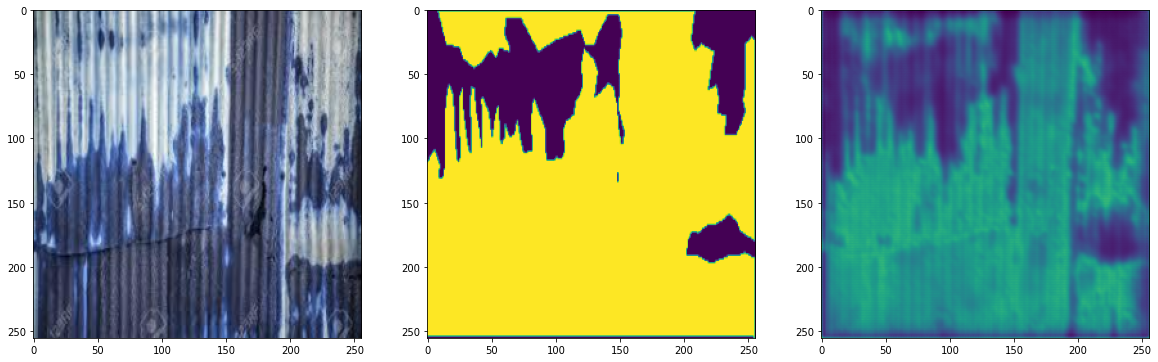

In [13]:
figure, j = plt.subplots(1, 3, figsize=(20,20))
j[0].imshow(test_img[0])
j[1].imshow(test_mask[0].squeeze())
j[2].imshow(prediction[0].squeeze())

# Prediction using new image

In [14]:
!mkdir '/content/save_images'

In [15]:
files.upload()

Saving 000001.jpg to 000001.jpg


{'000001.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe1\x02\xf0Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\n\x01\x0f\x00\x02\x00\x00\x00\x07\x00\x00\x00\x88\x01\x10\x00\x02\x00\x00\x00\r\x00\x00\x00\x90\x01\x12\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x01\x1a\x00\x05\x00\x00\x00\x01\x00\x00\x00\xa0\x01\x1b\x00\x05\x00\x00\x00\x01\x00\x00\x00\xa8\x01(\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x012\x00\x02\x00\x00\x00\x14\x00\x00\x00\xb0\x02\x13\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x00\xc4\x88%\x00\x04\x00\x00\x00\x01\x00\x00\x02d\x00\x00\x00\x00\x00\x00Lenovo\x00\x00Lenovo S60-a\x00\x00\x00\x00\x00\x00\x00H\x00\x00\x00\x01\x00\x00\x00H\x00\x00\x00\x012018:05:20 15:30:17\x00\x00\x16\x82\x9a\x00\x05\x00\x00\x00\x01\x00\x00\x01\xd4\x82\x9d\x00\x05\x00\x00\x00\x01\x00\x00\x01\xdc\x88\'\x00\x03\x00\x00\x00\x01\x00\xb3\x00\x00\x90\x00\x00\x07\x00\x00\x00\x040220\x90\x03\x00\x02\x00\x00\x00\x14\x00\x00\x01\xe4\x90\x04\x00\x

In [16]:
# Preprocessing
test_path = '/content/000001.jpg'

test_tensor = np.zeros((1, 256, 256, 3), dtype='float')

test = cv2.imread(test_path, cv2.IMREAD_COLOR)
ori_image = test
height, width, _ = test.shape
test = cv2.resize(test, (256, 256))
test = test / 255.0
test = test.astype('float')
test = np.expand_dims(test, axis=0)
test_tensor = test

In [17]:
prediction = model.predict(test_tensor)[0]

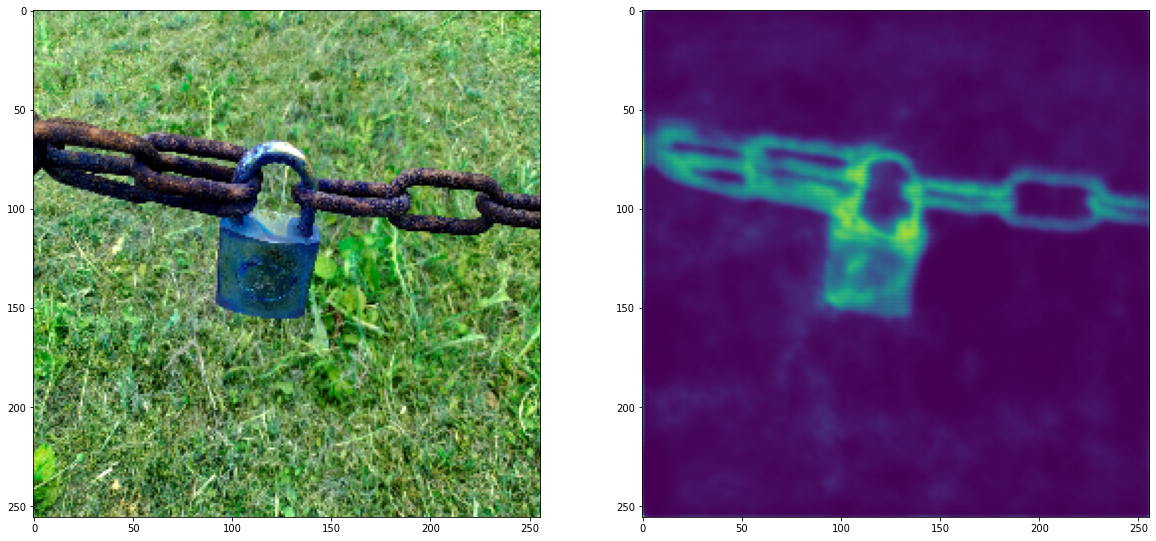

In [18]:
figure, j = plt.subplots(1, 2, figsize=(20,20))
j[0].imshow(test_tensor[0])
j[1].imshow(prediction.squeeze())

In [19]:
prediction = np.concatenate(
    [
        prediction,
        prediction,
        prediction
    ], axis=2)

prediction = prediction * 255
prediction = prediction.astype(np.float32)
prediction = cv2.resize(prediction, (width, height))

ori_image = ori_image.astype(np.float32)

alpha = 0.8
cv2.addWeighted(prediction, alpha, ori_image, 1-alpha, 0, ori_image)

name = test_path.split("/")[-1]
    
cv2.imwrite(f"/content/save_images/{name}", ori_image)

True

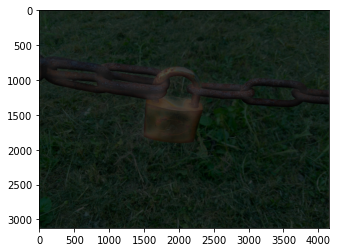

In [23]:
# Show image
image = cv2.imread("/content/save_images/000001.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

# Save model

In [24]:
model.save('/content/corrosion_segment_unet.hdf5')

# Reference

Code and model : 
* [Image segmentation with a U-Net-like architecture by fchollet](https://keras.io/examples/vision/oxford_pets_image_segmentation/)

* [My experiment with UNet – building an image segmentation model, by Rohit Dwivedi](https://analyticsindiamag.com/my-experiment-with-unet-building-an-image-segmentation-model/) 

* [UNET - Line by Line Explanation by Jeremy Zhang](https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5)

* [Understanding Semantic Segmentation with UNET by Harshall Lamba](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47)

* [UNET for Person Segmentation by Idiot Developer](https://youtu.be/qrL22HEaUGA)

Paper : 

* [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)